# **2. Preprocesamiento de datos y Modelados**

En esta seccion, vamos a empezar haciendo el preprocesado de los datos finales, y posteriormente modelando los diferentes modelos, con diferentes modificaciones en cada etapa.

## **2.1 Modelos benchmark (RandomForest, XGboost, CatBoost, LightGBM)**

Antes de todo, vamos a empezar importando las librerias que usaremos.

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay, RocCurveDisplay,
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from lightgbm import LGBMClassifier

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, classification_report
)

from imblearn.over_sampling import SMOTE
import joblib
import pikl

Acto seguido, vamos a cargar los datos y hacer la separacion de las columnas categoricas y numericas para entrenar el modelo y nuestras "X". Este proceso va a ser analogo en todas las etapas.

In [ ]:
df = pd.read_csv("data_churn_EDA.csv")

In [ ]:
X = df.drop("churn", axis=1)
y = df["churn"]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

Luego de este split, vamos a aplicar el StandardScaler() a las variables numericas y OneHotEncoder a nuestras variables categoricas para futuro modelaje.

In [ ]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

print("Categóricas:", cat_cols)
print("Numéricas:", num_cols)

Categóricas: ['gender', 'senior', 'partner', 'dependents', 'phone', 'phone_multiple', 'internet', 'internet_security', 'internet_backup', 'internet_protection', 'internet_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless', 'payment']
Numéricas: ['tenure', 'charges_monthly']


Aqui, usaremos solamente los modelos estandares:

- Random Forest
- XGBoost
- CatBoost
- LightGBM

In [ ]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_seed=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

Y con ello, tambien haremos los respectivos pipelines para evitar cualquier fuga de datos dentro del proceso.

In [ ]:
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

pipe_cat = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", CatBoostClassifier(verbose=0, random_seed=42))
])

pipe_lgb = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LGBMClassifier(random_state=42))
])

In [ ]:
pipelines = {
    "RandomForest": pipe_rf,
    "XGBoost": pipe_xgb,
    "CatBoost": pipe_cat,
    "LightGBM": pipe_lgb
}

print(" Pipelines creados manualmente para cada modelo:")
for name in pipelines:
    print(f" - {name}")

 Pipelines creados manualmente para cada modelo:
 - RandomForest
 - XGBoost
 - CatBoost
 - LightGBM


Junto a ello, a pesar de que no usaremos hiperparametros, usaremos validacion cruzada para entrenar los modelos, y acumularemos los resultados para analizarlos a nivel global mas adelante.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids_empty = {
    "RandomForest": {},
    "XGBoost": {},
    "CatBoost": {},
    "LightGBM": {}
}

resultados1 = []

### **2.1.1 RandomForest**

In [ ]:
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid={},  
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:
inicio = time.time()
grid_rf.fit(X_train, y_train)
fin = time.time()

y_pred_rf = grid_rf.predict(X_test)

print("\nResultados - RandomForest")
print(classification_report(y_test, y_pred_rf))
print("Mejores parámetros:", grid_rf.best_params_)

resultados1.append({
    "Modelo": "RandomForest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "AUC": roc_auc_score(y_test, y_pred_rf),
    "Tiempo (s)": round(fin - inicio, 2),
    "Mejores Parámetros": grid_rf.best_params_
})

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Resultados - RandomForest
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1035
           1       0.60      0.49      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409

Mejores parámetros: {}


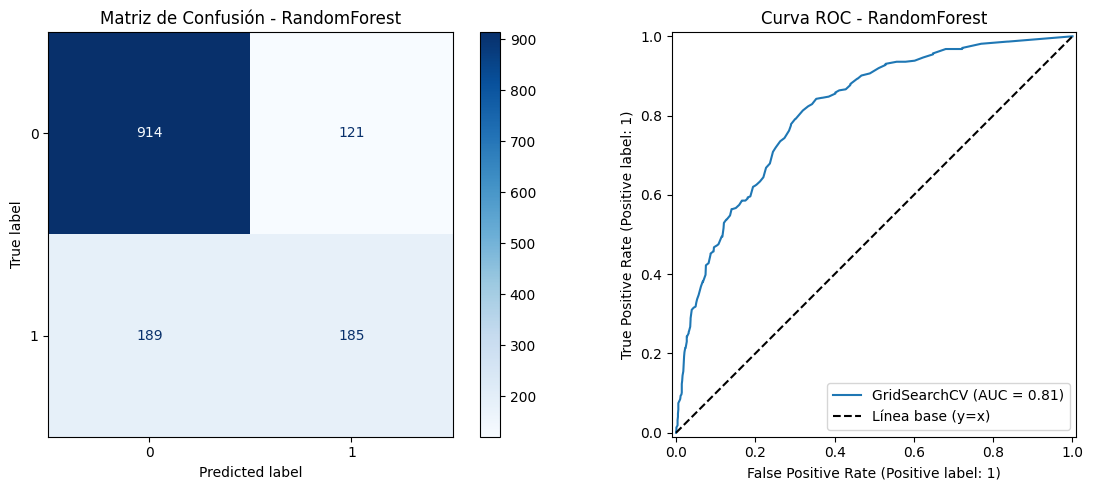

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(
    grid_rf, X_test, y_test, cmap="Blues", ax=axes[0]
)
axes[0].set_title("Matriz de Confusión - RandomForest")

RocCurveDisplay.from_estimator(grid_rf, X_test, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--", label="Línea base (y=x)")
axes[1].set_title("Curva ROC - RandomForest")
axes[1].legend()

plt.tight_layout()
plt.show()

El conjunto de resultados del **Modelo inicial** de Random Forest nos da un resultado útil, presentando un rendimiento de prueba sólido con una **Accuracy de 0.78** y un **AUC de 0.81**. La matriz de confusión demuestra un desempeño normal, enfatizando el desbalance que hay entre las clases, ya que la clase mayoritaria (positiva) tiene mayores tasas de clasificacion a diferencia de la clase negativa. En esta ultima clase, la tasa tanto de positivos como negativos es casi equivalente.

El reporte de clasificación muestra que el modelo es mejor en la identificación de la clase **'0'** (clase 1), logrando un **Recall de 0.69**. Este rendimiento indica una situacion interesante de desbalanceo entre las clases, y veremos si esto cambia a medida que implementemos diversos metodos de balanceo e hiperparametrizacion.

### **2.1.2 XGBoost**

In [ ]:
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid={},
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:
inicio = time.time()
grid_xgb.fit(X_train, y_train)
fin = time.time()

y_pred_xgb = grid_xgb.predict(X_test)

print("\nResultados - XGBoost")
print(classification_report(y_test, y_pred_xgb))
print("Mejores parámetros:", grid_xgb.best_params_)

resultados1.append({
    "Modelo": "XGBoost",
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "F1": f1_score(y_test, y_pred_xgb),
    "AUC": roc_auc_score(y_test, y_pred_xgb),
    "Tiempo (s)": round(fin - inicio, 2),
    "Mejores Parámetros": grid_xgb.best_params_
})

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Resultados - XGBoost
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1035
           1       0.60      0.51      0.55       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409

Mejores parámetros: {}


c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


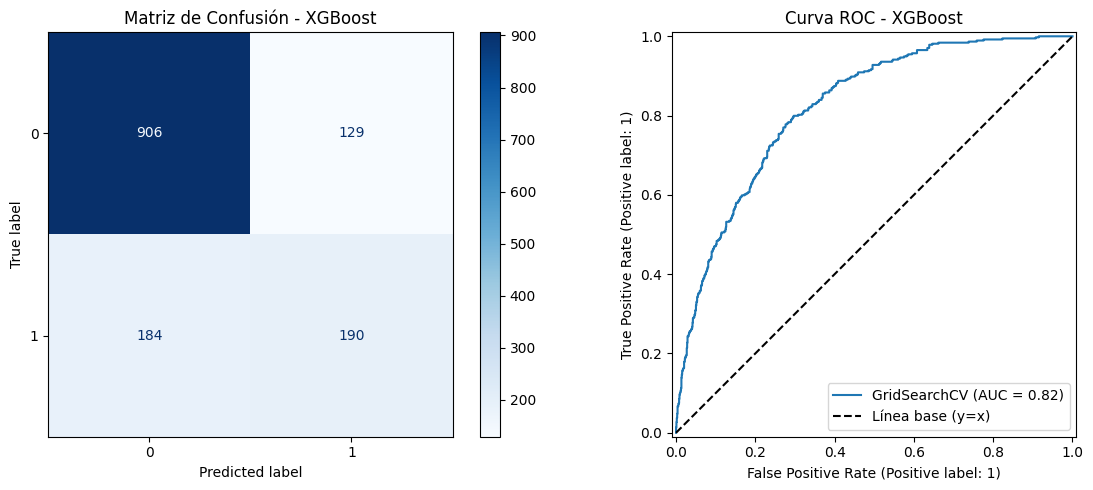

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(grid_xgb, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - XGBoost")

RocCurveDisplay.from_estimator(grid_xgb, X_test, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--", label="Línea base (y=x)")
axes[1].set_title("Curva ROC - XGBoost")
axes[1].legend()

plt.tight_layout()
plt.show()

El conjunto de resultados del **Modelo inicial** de XGBoost nos da un resultado útil, presentando un rendimiento de prueba sólido con una **Accuracy de 0.78** y un **AUC de 0.82**. La matriz de confusión demuestra un desempeño normal, enfatizando el desbalance que hay entre las clases, ya que la clase mayoritaria (positiva) tiene mayores tasas de clasificacion a diferencia de la clase negativa. En esta ultima clase, la tasa tanto de positivos como negativos es casi equivalente.

El reporte de clasificación muestra que el modelo es mejor en la identificación de la clase **'0'** (clase 1), logrando un **Recall de 0.69**. Este rendimiento indica una situacion interesante de desbalanceo entre las clases, y veremos si esto cambia a medida que implementemos diversos metodos de balanceo e hiperparametrizacion.

### **2.1.3 CatBoost**

In [ ]:
grid_cat = GridSearchCV(
    estimator=pipe_cat,
    param_grid={},
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:
inicio = time.time()
grid_cat.fit(X_train, y_train)
fin = time.time()

y_pred_cat = grid_cat.predict(X_test)

print("\nResultados - CatBoost")
print(classification_report(y_test, y_pred_cat))
print("Mejores parámetros:", grid_cat.best_params_)

resultados1.append({
    "Modelo": "CatBoost",
    "Accuracy": accuracy_score(y_test, y_pred_cat),
    "Recall": recall_score(y_test, y_pred_cat),
    "Precision": precision_score(y_test, y_pred_cat),
    "F1": f1_score(y_test, y_pred_cat),
    "AUC": roc_auc_score(y_test, y_pred_cat),
    "Tiempo (s)": round(fin - inicio, 2),
    "Mejores Parámetros": grid_cat.best_params_
})

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Resultados - CatBoost
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409

Mejores parámetros: {}


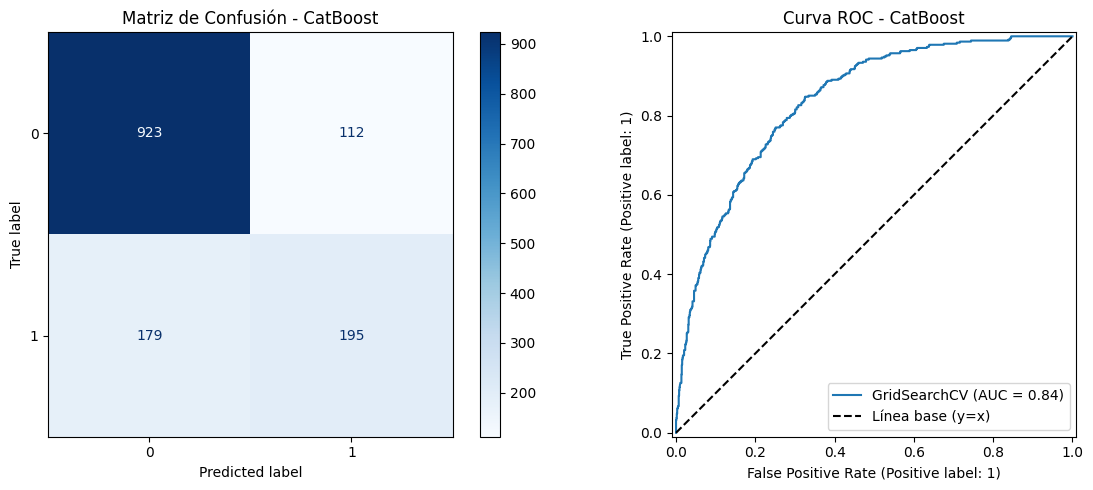

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(grid_cat, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - CatBoost")

RocCurveDisplay.from_estimator(grid_cat, X_test, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--", label="Línea base (y=x)")
axes[1].set_title("Curva ROC - CatBoost")
axes[1].legend()

plt.tight_layout()
plt.show()

El conjunto de resultados del **Modelo inicial** de CatBoost nos da un resultado útil, presentando un rendimiento de prueba sólido con una **Accuracy de 0.79** y un **AUC de 0.84**. La matriz de confusión demuestra un desempeño ligeramente moderado, enfatizando el desbalance que hay entre las clases, ya que la clase mayoritaria (positiva) tiene mayores tasas de clasificacion a diferencia de la clase negativa. En esta ultima clase, la tasa tanto de positivos como negativos es casi equivalente.

El reporte de clasificación muestra que el modelo es mejor en la identificación de la clase **'0'** (clase 1), logrando un **Recall de 0.71**. Este rendimiento indica una situacion interesante de desbalanceo entre las clases, y veremos si esto cambia a medida que implementemos diversos metodos de balanceo e hiperparametrizacion.

### **2.1.4 LightGBM**

In [ ]:
grid_lgb = GridSearchCV(
    estimator=pipe_lgb,
    param_grid={},
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,265353 -> initscore=-1,018328
[LightGBM] [Info] Start training from score -1,018328

Resultados - LightGBM
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409

Mejores parámetros: {}


c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


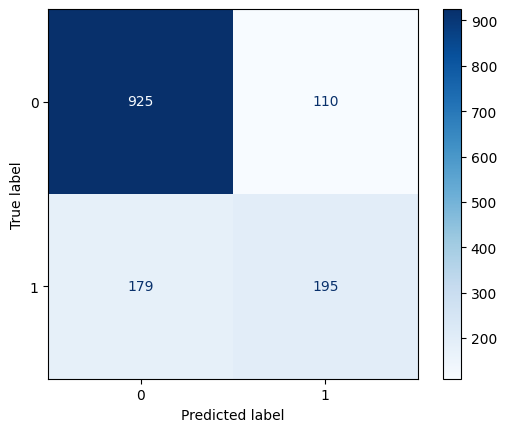

In [ ]:
inicio = time.time()
grid_lgb.fit(X_train, y_train)
fin = time.time()

y_pred_lgb = grid_lgb.predict(X_test)

print("\nResultados - LightGBM")
print(classification_report(y_test, y_pred_lgb))
print("Mejores parámetros:", grid_lgb.best_params_)

ConfusionMatrixDisplay.from_estimator(grid_lgb, X_test, y_test, cmap="Blues")

resultados1.append({
    "Modelo": "LightGBM",
    "Accuracy": accuracy_score(y_test, y_pred_lgb),
    "Recall": recall_score(y_test, y_pred_lgb),
    "Precision": precision_score(y_test, y_pred_lgb),
    "F1": f1_score(y_test, y_pred_lgb),
    "AUC": roc_auc_score(y_test, y_pred_lgb),
    "Tiempo (s)": round(fin - inicio, 2),
    "Mejores Parámetros": grid_lgb.best_params_
})

c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


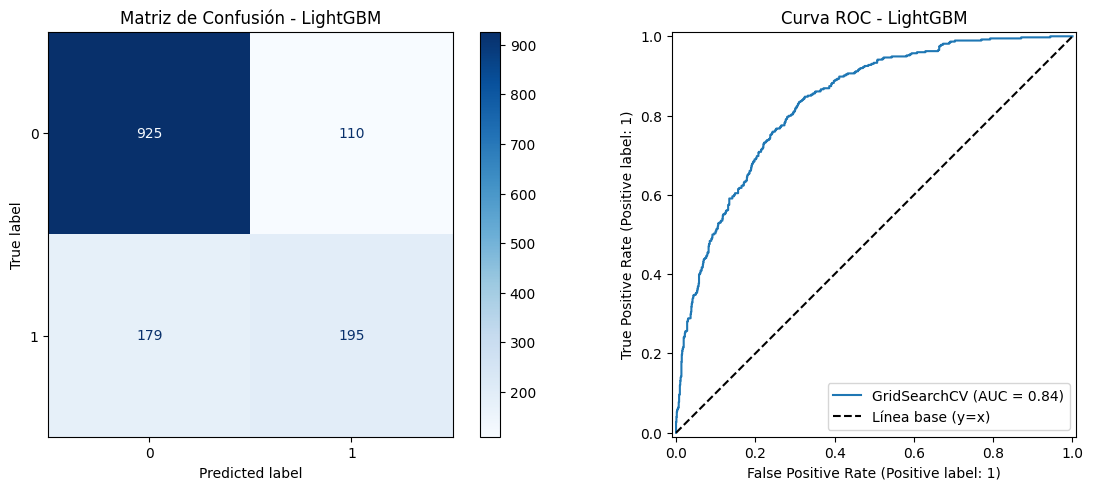

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(grid_lgb, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - LightGBM")

RocCurveDisplay.from_estimator(grid_lgb, X_test, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--", label="Línea base (y=x)")
axes[1].set_title("Curva ROC - LightGBM")
axes[1].legend()

plt.tight_layout()
plt.show()


El conjunto de resultados del **Modelo inicial** de LightGBM nos da un resultado útil, presentando un rendimiento de prueba sólido con una **Accuracy de 0.79** y un **AUC de 0.84**. La matriz de confusión demuestra un desempeño normal, enfatizando el desbalance que hay entre las clases, ya que la clase mayoritaria (positiva) tiene mayores tasas de clasificacion a diferencia de la clase negativa. En esta ultima clase, la tasa tanto de positivos como negativos es casi equivalente.

El reporte de clasificación muestra que el modelo es mejor en la identificación de la clase **'0'** (clase 1), logrando un **Recall de 0.71**. Este rendimiento indica una situacion interesante de desbalanceo entre las clases, y veremos si esto cambia a medida que implementemos diversos metodos de balanceo e hiperparametrizacion.

### **2.1.5 Resultados Preliminares**

In [ ]:
res1_df = pd.DataFrame(resultados1)
res1_df_sorted = res1_df.sort_values(by="Recall", ascending=False)
print("\n Resultados finales:")
display(res1_df_sorted)


 Resultados finales:


,Modelo,Accuracy,Recall,Precision,F1,AUC,Tiempo (s),Mejores Parámetros
2,CatBoost,0.793471,0.521390,0.635179,0.572687,0.706589,8.13,{}
3,LightGBM,0.794890,0.521390,0.639344,0.574374,0.707555,0.93,{}
1,XGBoost,0.777857,0.508021,0.595611,0.548341,0.691692,0.64,{}
0,RandomForest,0.779986,0.494652,0.604575,0.544118,0.688872,1.07,{}


In [ ]:
metricas = ["Accuracy", "Recall", "Precision", "F1", "AUC"]

res1_df_sorted = res1_df.sort_values(by="Recall", ascending=False).reset_index(drop=True)

res1_melt = res1_df_sorted.melt(
    id_vars="Modelo", 
    value_vars=metricas, 
    var_name="Métrica", 
    value_name="Valor"
)

C:\Users\taran\AppData\Local\Temp\ipykernel_19104\1102010564.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


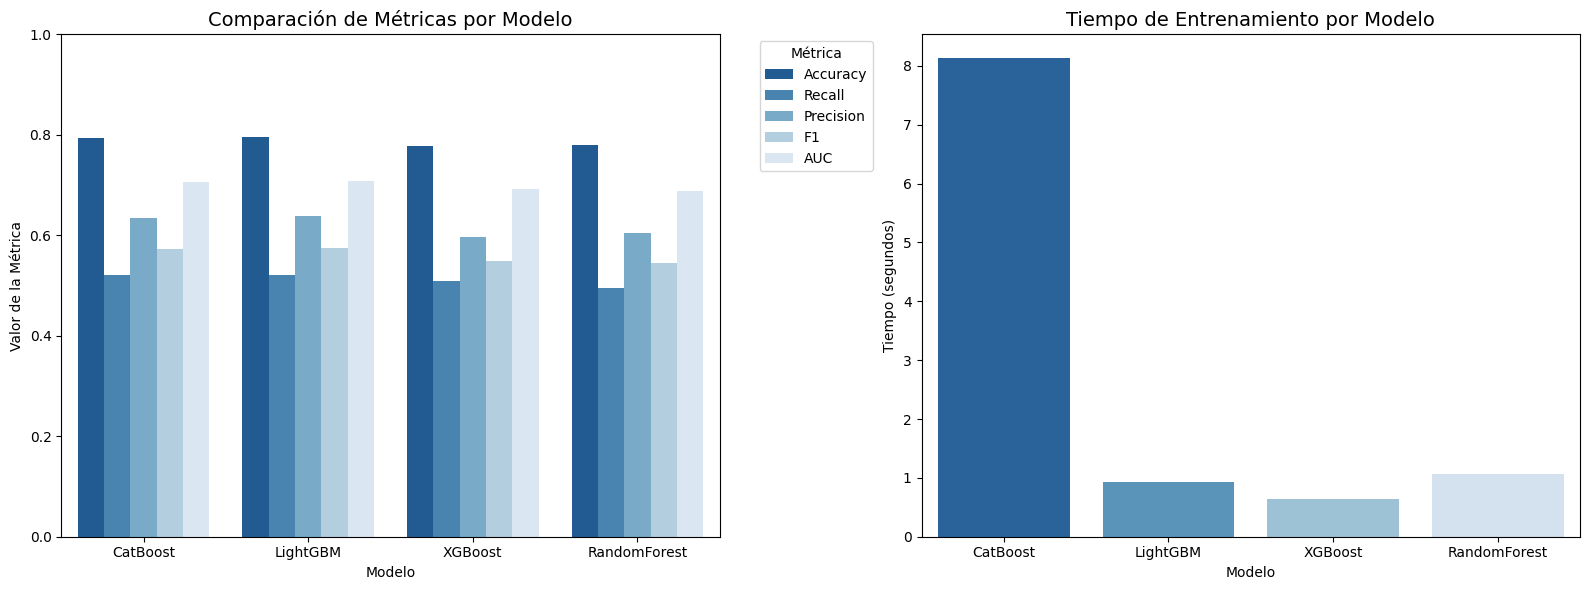

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(
    data=res1_melt, 
    x="Modelo", 
    y="Valor", 
    hue="Métrica", 
    palette="Blues_r", 
    ax=axes[0]
)
axes[0].set_title("Comparación de Métricas por Modelo", fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("Valor de la Métrica")
axes[0].set_xlabel("Modelo")
axes[0].legend(title="Métrica", bbox_to_anchor=(1.05, 1), loc="upper left")

sns.barplot(
    data=res1_df_sorted, 
    x="Modelo", 
    y="Tiempo (s)", 
    palette="Blues_r", 
    ax=axes[1]
)
axes[1].set_title("Tiempo de Entrenamiento por Modelo", fontsize=14)
axes[1].set_ylabel("Tiempo (segundos)")
axes[1].set_xlabel("Modelo")

plt.tight_layout()
plt.show()


De forma preliminar, vemos que los modelos de CatBoost y LightGBM tienen mejores metricas al comparar con otros modelos. En este caso, la metrica de interes es Recall (ya que queremos reducir los falsos negativos para este caso), y tanto CatBoost como LightGBM alcanzaron los mejores rendimientos. Junto a esto, notamos que CatBoost tuvo una duracion elevada a comparacion del resto (LightGBM, XGBoost y RandomForest)

c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


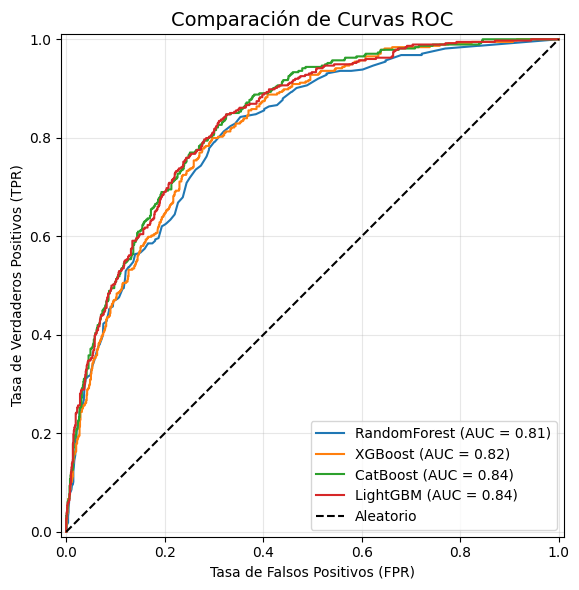

In [ ]:
plt.figure(figsize=(8, 6))

modelos_entrenados = {
    "RandomForest": grid_rf,
    "XGBoost": grid_xgb,
    "CatBoost": grid_cat,
    "LightGBM": grid_lgb
}

for name, model in modelos_entrenados.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=plt.gca(), name=name)

plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")

plt.title("Comparación de Curvas ROC", fontsize=14)
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Comparando curvas ROC, los rendimientos son bastantes similares a la grafica anterior, con LightGBM y CatBoost con un AUC de 0.84, con los modelos restantes estando con 0.82 (XGboost) y 0.81 (RandomForest) respectivamente, teniendo un desempeño similar.

## **2.2. Modelos benchmark (RandomForest, XGboost, CatBoost, LightGBM) con hiperparametros establecidos**

En esta seccion, haremos analogamente a lo que hicimos a la seccion anterior, pero implementaremos diferentes hiperparametros para revisar su rendimiento.

In [ ]:
df = pd.read_csv("data_churn_EDA.csv")

In [ ]:
X = df.drop("churn", axis=1)
y = df["churn"]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

print("Categóricas:", cat_cols)
print("Numéricas:", num_cols)

Categóricas: ['gender', 'senior', 'partner', 'dependents', 'phone', 'phone_multiple', 'internet', 'internet_security', 'internet_backup', 'internet_protection', 'internet_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless', 'payment']
Numéricas: ['tenure', 'charges_monthly']


In [ ]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_seed=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [ ]:
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

pipe_cat = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", CatBoostClassifier(verbose=0, random_seed=42))
])

pipe_lgb = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LGBMClassifier(random_state=42))
])


In [ ]:
pipelines = {
    "RandomForest": pipe_rf,
    "XGBoost": pipe_xgb,
    "CatBoost": pipe_cat,
    "LightGBM": pipe_lgb
}

print(" Pipelines creados manualmente para cada modelo:")
for name in pipelines:
    print(f" - {name}")

 Pipelines creados manualmente para cada modelo:
 - RandomForest
 - XGBoost
 - CatBoost
 - LightGBM


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    "RandomForest": {
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__max_features": ["sqrt", "log2"],
        "clf__bootstrap": [True, False],
        "clf__criterion": ["gini", "entropy"]
    },
    
    "XGBoost": {
        "clf__subsample": [0.8, 1.0],
        "clf__gamma": [0, 1],
        "clf__min_child_weight": [1, 5],
        "clf__reg_alpha": [0, 0.1, 0.5],
        "clf__reg_lambda": [1, 2, 5],
        "clf__scale_pos_weight": [1, 2, 5]
    },

    "CatBoost": {
        "clf__l2_leaf_reg": [1, 3, 5],
        "clf__border_count": [32, 64],
    },

    "LightGBM": {
        "clf__min_child_samples": [10, 20, 50],
        "clf__min_child_weight": [1e-3, 1e-2, 1e-1],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0],
        "clf__reg_alpha": [0],
        "clf__reg_lambda": [0, 0.5, 1],
        "clf__max_bin": [255]
    }
}

resultados2 = []

### **2.2.1 RandomForest**

In [ ]:
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grids["RandomForest"],
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:
inicio = time.time()
grid_rf.fit(X_train, y_train)
fin = time.time()

y_pred_rf = grid_rf.predict(X_test)

print("\n Resultados - RandomForest")
print(classification_report(y_test, y_pred_rf))
print("---------------------------------------------")
print("Mejores parámetros:", grid_rf.best_params_)

resultados2.append({
    "Modelo": "RandomForest + HP",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "AUC": roc_auc_score(y_test, y_pred_rf),
    "Tiempo (s)": round(fin - inicio, 2),
    "Mejores Parámetros": grid_rf.best_params_
})

Fitting 5 folds for each of 72 candidates, totalling 360 fits

 Resultados - RandomForest
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

---------------------------------------------
Mejores parámetros: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5}


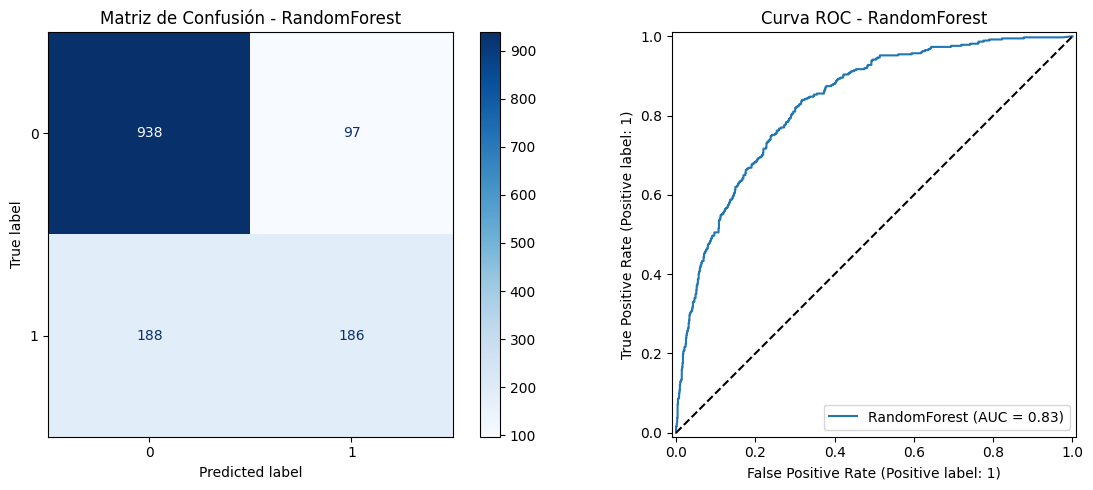

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(grid_rf, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - RandomForest")

RocCurveDisplay.from_estimator(grid_rf, X_test, y_test, ax=axes[1], name="RandomForest")
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_title("Curva ROC - RandomForest")

plt.tight_layout()
plt.show()

El conjunto de resultados del **Modelo Hiperparametrizado** de Random Forest nos da un resultado interesante, presentando un rendimiento de prueba sólido con una **Accuracy de 0.80** y un **AUC de 0.83**. La matriz de confusión demuestra un desempeño normal, enfatizando el desbalance que hay entre las clases, ya que la clase mayoritaria (positiva) tiene mayores tasas de clasificacion a diferencia de la clase negativa. En esta ultima clase, la tasa tanto de positivos como negativos es casi equivalente.

El reporte de clasificación muestra que el modelo es mejor en la identificación de la clase **'0'** (clase 1), logrando un **Recall de 0.70**. Este rendimiento indica una situacion interesante de desbalanceo entre las clases, y veremos si esto cambia a medida que implementemos diversos metodos de balanceo e hiperparametrizacion.

Los mejores parametros fueron: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5}


### **2.2.2 XGBoost**

In [ ]:
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grids["XGBoost"],
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:
inicio = time.time()
grid_xgb.fit(X_train, y_train)
fin = time.time()

y_pred_xgb = grid_xgb.predict(X_test)

print("\n Resultados - XGBoost")
print(classification_report(y_test, y_pred_xgb))
print("---------------------------------------------")
print("Mejores parámetros:", grid_xgb.best_params_)


resultados2.append({
    "Modelo": "XGBoost + HP",
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "F1": f1_score(y_test, y_pred_xgb),
    "AUC": roc_auc_score(y_test, y_pred_xgb),
    "Tiempo (s)": round(fin - inicio, 2),
    "Mejores Parámetros": grid_xgb.best_params_
})

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

 Resultados - XGBoost
              precision    recall  f1-score   support

           0       0.92      0.66      0.77      1035
           1       0.47      0.85      0.61       374

    accuracy                           0.71      1409
   macro avg       0.70      0.75      0.69      1409
weighted avg       0.80      0.71      0.73      1409

---------------------------------------------
Mejores parámetros: {'clf__gamma': 1, 'clf__min_child_weight': 5, 'clf__reg_alpha': 0, 'clf__reg_lambda': 5, 'clf__scale_pos_weight': 5, 'clf__subsample': 1.0}


c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


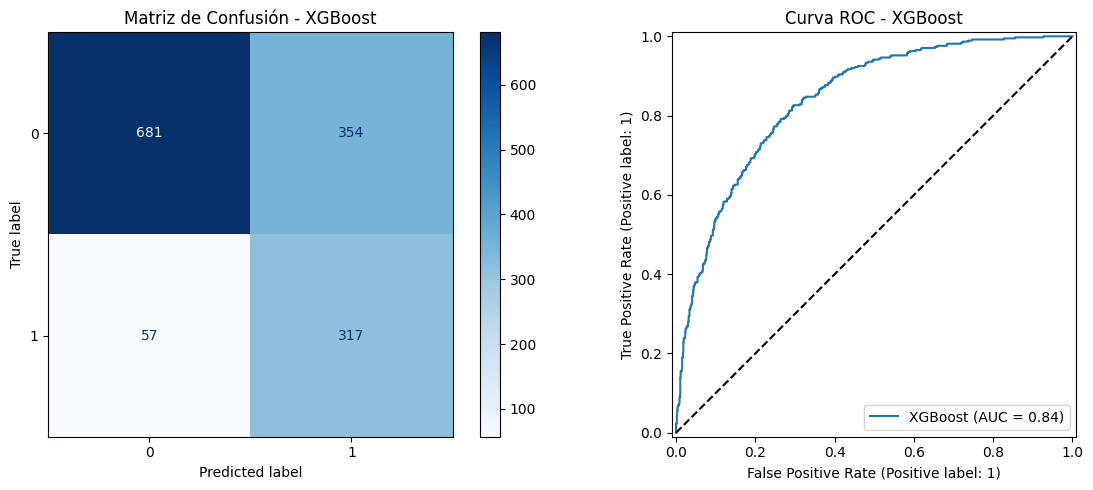

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(grid_xgb, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - XGBoost")

RocCurveDisplay.from_estimator(grid_xgb, X_test, y_test, ax=axes[1], name="XGBoost")
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_title("Curva ROC - XGBoost")

plt.tight_layout()
plt.show()

El conjunto de resultados del **Modelo Hiperparametrizado** de XGBoost nos da un resultado interesante, presentando un rendimiento de prueba sólido con una **Accuracy de 0.71** y un **AUC de 0.84**. La matriz de confusión demuestra un desempeño diferente al planteado, donde se tuvo una mejoria en la clasificacion de la clase 1, a costo de la clase mayoritaria 0.

El reporte de clasificación muestra que el modelo es mejor en la identificación de la clase **'0'** (clase 1), logrando un **Recall de 0.75**. Este rendimiento indica una situacion interesante de desbalanceo entre las clases, y veremos si esto cambia a medida que implementemos diversos metodos de balanceo e hiperparametrizacion.

Los mejores parametros fueron: {'clf__gamma': 1, 'clf__min_child_weight': 5, 'clf__reg_alpha': 0, 'clf__reg_lambda': 5, 'clf__scale_pos_weight': 5, 'clf__subsample': 1.0}


### **2.2.3 CatBoost**

In [ ]:
grid_cat = GridSearchCV(
    estimator=pipe_cat,
    param_grid=param_grids["CatBoost"],
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:
inicio = time.time()
grid_cat.fit(X_train, y_train)
fin = time.time()

y_pred_cat = grid_cat.predict(X_test)

print("\nResultados - CatBoost")
print(classification_report(y_test, y_pred_cat))
print("---------------------------------------------")
print("Mejores parámetros:", grid_cat.best_params_)

resultados2.append({
    "Modelo": "CatBoost + HP",
    "Accuracy": accuracy_score(y_test, y_pred_cat),
    "Recall": recall_score(y_test, y_pred_cat),
    "Precision": precision_score(y_test, y_pred_cat),
    "F1": f1_score(y_test, y_pred_cat),
    "AUC": roc_auc_score(y_test, y_pred_cat),
    "Tiempo (s)": round(fin - inicio, 2),
    "Mejores Parámetros": grid_cat.best_params_
})


Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Resultados - CatBoost
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.62      0.55      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409

---------------------------------------------
Mejores parámetros: {'clf__border_count': 32, 'clf__l2_leaf_reg': 1}


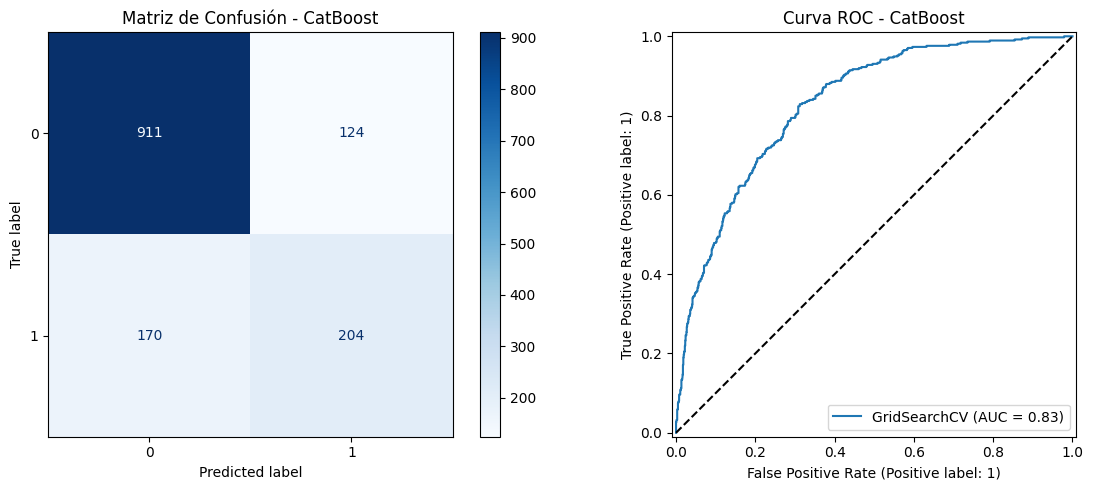

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(grid_cat, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - CatBoost")

RocCurveDisplay.from_estimator(grid_cat, X_test, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_title("Curva ROC - CatBoost")
axes[1].legend()

plt.tight_layout()
plt.show()

El conjunto de resultados del **Modelo Hiperparametrizado** de CatBoost nos da un resultado interesante, presentando un rendimiento de prueba sólido con una **Accuracy de 0.79** y un **AUC de 0.83**. La matriz de confusión demuestra un desempeño diferente al planteado, donde se tuvo una mejoria en la clasificacion de la clase 1, a costo de la clase mayoritaria 0.

El reporte de clasificación muestra que el modelo es mejor en la identificación de la clase **'0'** (clase 1), logrando un **Recall de 0.71**. Este rendimiento indica una situacion interesante de desbalanceo entre las clases, y veremos si esto cambia a medida que implementemos diversos metodos de balanceo e hiperparametrizacion.

 En este caso, los mejores parametros fueron {'clf__border_count': 32, 'clf__l2_leaf_reg': 1}


### **2.2.4 LightGBM**

In [ ]:
grid_lgb = GridSearchCV(
    estimator=pipe_lgb,
    param_grid=param_grids["LightGBM"],
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,265353 -> initscore=-1,018328
[LightGBM] [Info] Start training from score -1,018328

Resultados - LightGBM
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.51      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

Mejores parámetros: {'clf__colsam

c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


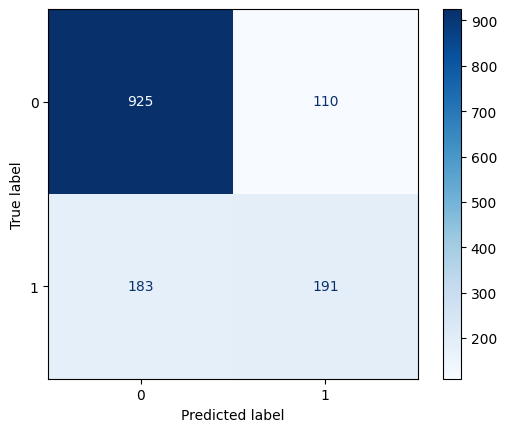

In [ ]:
inicio = time.time()
grid_lgb.fit(X_train, y_train)
fin = time.time()

y_pred_lgb = grid_lgb.predict(X_test)

print("\nResultados - LightGBM")
print(classification_report(y_test, y_pred_lgb))
print("Mejores parámetros:", grid_lgb.best_params_)

ConfusionMatrixDisplay.from_estimator(grid_lgb, X_test, y_test, cmap="Blues")

resultados2.append({
    "Modelo": "LightGBM + HP",
    "Accuracy": accuracy_score(y_test, y_pred_lgb),
    "Recall": recall_score(y_test, y_pred_lgb),
    "Precision": precision_score(y_test, y_pred_lgb),
    "F1": f1_score(y_test, y_pred_lgb),
    "AUC": roc_auc_score(y_test, y_pred_lgb),
    "Tiempo (s)": round(fin - inicio, 2),
    "Mejores Parámetros": grid_lgb.best_params_
})

c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


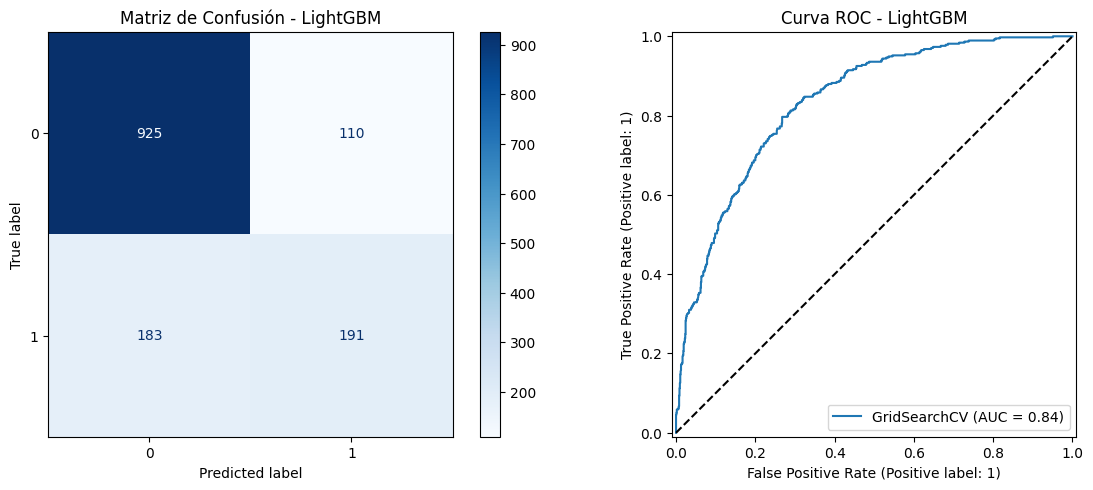

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(grid_lgb, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - LightGBM")

RocCurveDisplay.from_estimator(grid_lgb, X_test, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_title("Curva ROC - LightGBM")
axes[1].legend()

plt.tight_layout()
plt.show()

El conjunto de resultados del **Modelo Hiperparametrizado** de LightGBM nos da un resultado interesante, presentando un rendimiento de prueba sólido con una **Accuracy de 0.79** y un **AUC de 0.84**. La matriz de confusión demuestra un desempeño diferente al planteado, donde se tuvo una mejoria en la clasificacion de la clase 1, a costo de la clase mayoritaria 0.

El reporte de clasificación muestra que el modelo es mejor en la identificación de la clase **'0'** (clase 1), logrando un **Recall de 0.70**. Este rendimiento indica una situacion interesante de desbalanceo entre las clases, y veremos si esto cambia a medida que implementemos diversos metodos de balanceo e hiperparametrizacion.

 En este caso, los mejores parametros fueron: {'clf__colsample_bytree': 1.0, 'clf__max_bin': 255, 'clf__min_child_samples': 10, 'clf__min_child_weight': 0.001, 'clf__reg_alpha': 0, 'clf__reg_lambda': 1, 'clf__subsample': 0.8}


### **2.2.5 Resultados Preliminares**

In [ ]:
res2_df = pd.DataFrame(resultados2)
res2_df_sorted = res2_df.sort_values(by="Recall", ascending=False)
print("\n Resultados finales:")
display(res2_df_sorted)


 Resultados finales:


,Modelo,Accuracy,Recall,Precision,F1,AUC,Tiempo (s),Mejores Parámetros
1,XGBoost + HP,0.708304,0.847594,0.472429,0.606699,0.752782,24.53,"{'clf__gamma': 1, 'clf__min_child_weight': 5, ..."
2,CatBoost + HP,0.791341,0.545455,0.621951,0.581197,0.712824,30.81,"{'clf__border_count': 32, 'clf__l2_leaf_reg': 1}"
3,LightGBM + HP,0.792051,0.510695,0.634551,0.565926,0.702207,42.95,"{'clf__colsample_bytree': 1.0, 'clf__max_bin':..."
0,RandomForest + HP,0.797729,0.497326,0.657244,0.566210,0.701803,25.00,"{'clf__bootstrap': True, 'clf__criterion': 'gi..."


In [ ]:
metricas = ["Accuracy", "Recall", "Precision", "F1", "AUC"]

res2_df_sorted = res2_df.sort_values(by="Recall", ascending=False).reset_index(drop=True)

res2_melt = res2_df_sorted.melt(
    id_vars="Modelo", 
    value_vars=metricas, 
    var_name="Métrica", 
    value_name="Valor"
)

C:\Users\taran\AppData\Local\Temp\ipykernel_19104\2340569329.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


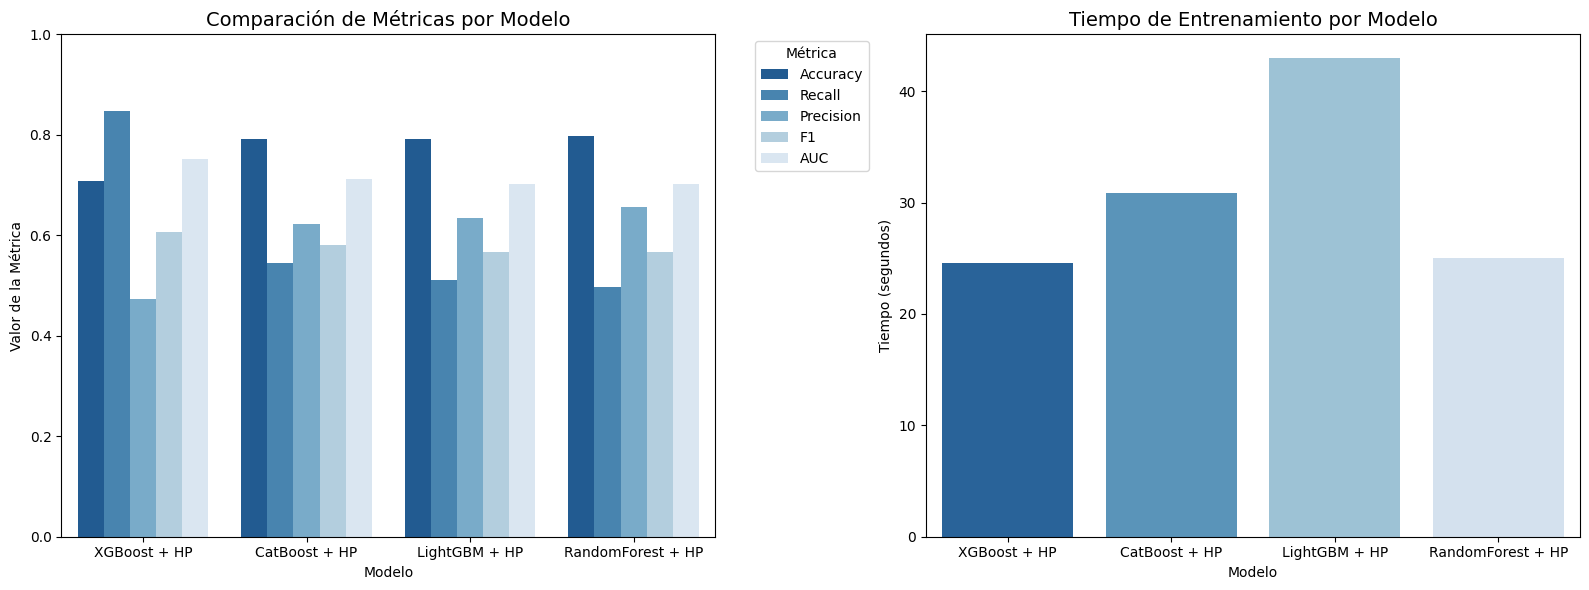

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(
    data=res2_melt, 
    x="Modelo", 
    y="Valor", 
    hue="Métrica", 
    palette="Blues_r", 
    ax=axes[0]
)
axes[0].set_title("Comparación de Métricas por Modelo", fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("Valor de la Métrica")
axes[0].set_xlabel("Modelo")
axes[0].legend(title="Métrica", bbox_to_anchor=(1.05, 1), loc="upper left")

sns.barplot(
    data=res2_df_sorted, 
    x="Modelo", 
    y="Tiempo (s)", 
    palette="Blues_r", 
    ax=axes[1]
)
axes[1].set_title("Tiempo de Entrenamiento por Modelo", fontsize=14)
axes[1].set_ylabel("Tiempo (segundos)")
axes[1].set_xlabel("Modelo")

plt.tight_layout()
plt.show()


De forma preliminar, vemos que los modelos de CatBoost y XGBoost tienen mejores metricas al comparar con otros modelos. En este caso, la metrica de interes es Recall (ya que queremos reducir los falsos negativos para este caso), y tanto XGBoost como LightGBM alcanzaron los mejores rendimientos. Junto a esto, notamos que XGBoost tuvo una duracion elevada a comparacion del resto (CatBoost, LightGBM y RandomForest)

Los modelos de XGBoost y RandomForest fueron los que menos duracion tuvieron a la hora de ejecutar.

c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


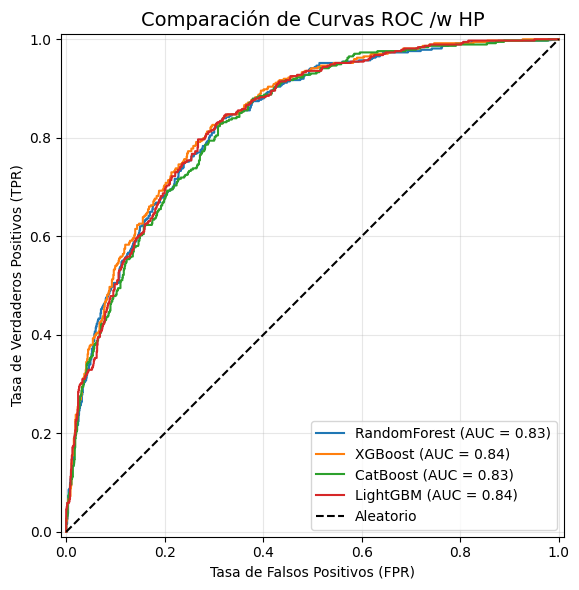

In [ ]:
plt.figure(figsize=(8, 6))

modelos_entrenados = {
    "RandomForest": grid_rf,
    "XGBoost": grid_xgb,
    "CatBoost": grid_cat,
    "LightGBM": grid_lgb
}

for name, model in modelos_entrenados.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=plt.gca(), name=name)

plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")

plt.title("Comparación de Curvas ROC /w HP", fontsize=14)
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Comparando curvas ROC, los rendimientos son bastantes similares a la grafica anterior, con LightGBM y XGBoost con un AUC de 0.84, con los modelos restantes estando con 0.83 (RandomForest) y 0.83 (CatBoost) respectivamente, teniendo un desempeño muy similar en comparacion.

## **2.3 Modelos con tecnicas de balanceo + GPU (RandomForest, XGboost, CatBoost, LightGBM) e hiperparametros establecidos**

Para esta ultima seccion, usaremos los modelos anteriores y aplicaremos el uso de GPU para maximizar el tiempo de computo, manteniendo la complejidad de los modelos, con hiperparametros y validacion cruzada entre estos. Junto a lo anterior, aplicaremos un metodo especifico de balanceo a cada modelo para observar su rendimiento.

In [ ]:
print("TensorFlow GPU disponible:", tf.config.list_physical_devices('GPU'))

TensorFlow GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
X_dummy = np.random.rand(1000, 10)
y_dummy = np.random.randint(0, 2, 1000)

model = XGBClassifier(
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    use_label_encoder=False,
    eval_metric="logloss"
)

model.fit(X_dummy, y_dummy)
print("XGBoost entrenado en GPU con éxito.")

c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost entrenado en GPU con éxito.


In [ ]:
model = LGBMClassifier(device="gpu")
print("LightGBM GPU activo:", model.get_params()["device"])

LightGBM GPU activo: gpu


In [ ]:
df = pd.read_csv("data_churn_EDA.csv")

In [ ]:
X = df.drop("churn", axis=1)
y = df["churn"]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

print("Categóricas:", cat_cols)
print("Numéricas:", num_cols)

smote = SMOTE(random_state=42)

Categóricas: ['gender', 'senior', 'partner', 'dependents', 'phone', 'phone_multiple', 'internet', 'internet_security', 'internet_backup', 'internet_protection', 'internet_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless', 'payment']
Numéricas: ['tenure', 'charges_monthly']


In [ ]:
n_pos = df['churn'].value_counts()[1]
n_neg = df['churn'].value_counts()[0]
w1 = n_neg / n_pos  
w0 = 1

models = {
    "RandomForest": RandomForestClassifier(
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        tree_method="hist",
        predictor="cpu_predictor",  # fuerza CPU en predicción
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=w1,  
        random_state=42
    ),

    "LightGBM": LGBMClassifier(
        device="gpu",
        is_unbalance=True, 
        random_state=42
    )
}

In [ ]:
from imblearn.pipeline import Pipeline


pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),  
    ("clf", models["RandomForest"])
])

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", models["XGBoost"])
])

pipe_lgb = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", models["LightGBM"]) 
])

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    "RandomForest": {
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__max_features": ["sqrt", "log2"],
        "clf__bootstrap": [True, False],
        "clf__criterion": ["gini", "entropy"]
    },
    "XGBoost": {
        "clf__subsample": [0.8, 1.0],
        "clf__gamma": [0, 1],
        "clf__min_child_weight": [1, 5],
        "clf__reg_alpha": [0, 0.1, 0.5],
        "clf__reg_lambda": [1, 2, 5],
        "clf__scale_pos_weight": [1, 2, 5]
    },

    "LightGBM": {
        "clf__min_child_samples": [10, 20, 50],
        "clf__min_child_weight": [1e-3, 1e-2, 1e-1],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0],
        "clf__reg_alpha": [0],
        "clf__reg_lambda": [0, 0.5, 1],
        "clf__max_bin": [255]
    }
}

resultados3 = []

### **2.3.1 RandomForest**

In [ ]:
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grids["RandomForest"],
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:
inicio = time.time()
grid_rf.fit(X_train, y_train)
fin = time.time()

y_pred_rf = grid_rf.predict(X_test)

print("\n Resultados - RandomForest")
print(classification_report(y_test, y_pred_rf))
print("---------------------------------------------")
print("Mejores parámetros:", grid_rf.best_params_)

resultados3.append({
    "Modelo": "RandomForest + HP + SMOTE (GPU)",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "AUC": roc_auc_score(y_test, y_pred_rf),
    "Tiempo (s)": round(fin - inicio, 2),
    "Mejores Parámetros": grid_rf.best_params_
})

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



 Resultados - RandomForest
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1035
           1       0.54      0.64      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.76      0.77      1409

---------------------------------------------
Mejores parámetros: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}


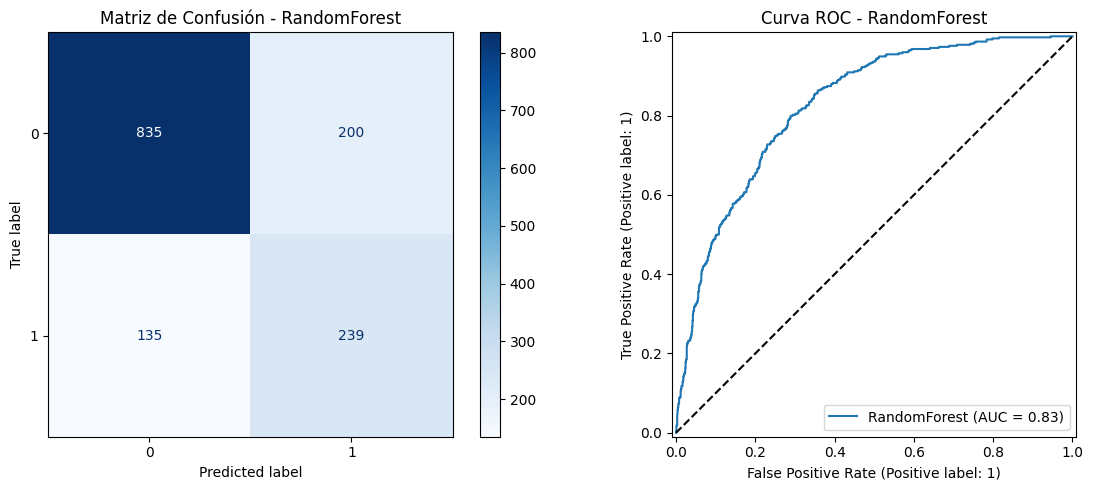

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(grid_rf, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - RandomForest")

RocCurveDisplay.from_estimator(grid_rf, X_test, y_test, ax=axes[1], name="RandomForest")
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_title("Curva ROC - RandomForest")

plt.tight_layout()
plt.show()

El conjunto de resultados del **Modelo Hiperparametrizado + Balaceno y GPU** de Random Forest nos da un resultado interesante, presentando un rendimiento de prueba sólido con una **Accuracy de 0.76** y un **AUC de 0.83**. La matriz de confusión demuestra un desempeño normal, enfatizando el desbalance que hay entre las clases, ya que la clase mayoritaria (positiva) tiene mayores tasas de clasificacion a diferencia de la clase negativa. En esta ultima clase, la tasa tanto de positivos como negativos es casi equivalente.

El reporte de clasificación muestra que el modelo es mejor en la identificación de la clase **'0'** (clase 1), logrando un **Recall de 0.72**. Este rendimiento indica una situacion interesante de desbalanceo entre las clases, y veremos si esto cambia a medida que implementemos diversos metodos de balanceo e hiperparametrizacion.

Los mejores parametros fueron: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}


### **2.3.2 XGBoost**

In [ ]:
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grids["XGBoost"],
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:
inicio = time.time()
grid_xgb.fit(X_train, y_train)
fin = time.time()

y_pred_xgb = grid_xgb.predict(X_test)

print("\n Resultados - XGBoost")
print(classification_report(y_test, y_pred_xgb))
print("---------------------------------------------")
print("Mejores parámetros:", grid_xgb.best_params_)

resultados3.append({
    "Modelo": "XGBoost + HP + scale_pos_weight=w1 (GPU)",
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "F1": f1_score(y_test, y_pred_xgb),
    "AUC": roc_auc_score(y_test, y_pred_xgb),
    "Tiempo (s)": round(fin - inicio, 2),
    "Mejores Parámetros": grid_xgb.best_params_
})

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

 Resultados - XGBoost
              precision    recall  f1-score   support

           0       0.92      0.66      0.77      1035
           1       0.47      0.85      0.61       374

    accuracy                           0.71      1409
   macro avg       0.70      0.75      0.69      1409
weighted avg       0.80      0.71      0.73      1409

---------------------------------------------
Mejores parámetros: {'clf__gamma': 1, 'clf__min_child_weight': 5, 'clf__reg_alpha': 0, 'clf__reg_lambda': 5, 'clf__scale_pos_weight': 5, 'clf__subsample': 1.0}


c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


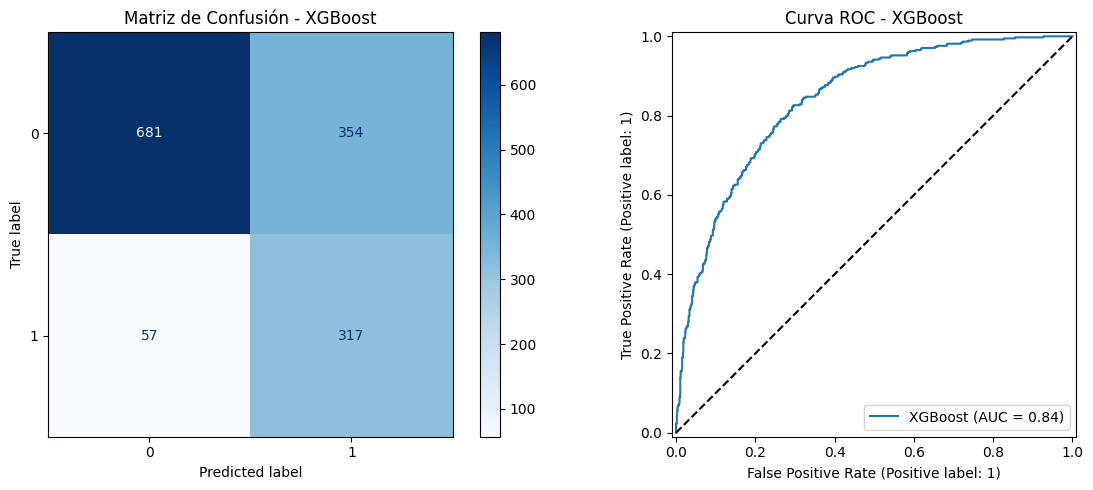

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(grid_xgb, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - XGBoost")

RocCurveDisplay.from_estimator(grid_xgb, X_test, y_test, ax=axes[1], name="XGBoost")
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_title("Curva ROC - XGBoost")

plt.tight_layout()
plt.show()

El conjunto de resultados del **Modelo Hiperparametrizado + Balaceno y GPU** de XGBoost nos da un resultado interesante, presentando un rendimiento de prueba sólido con una **Accuracy de 0.71** y un **AUC de 0.84**. La matriz de confusión demuestra un desempeño normal, enfatizando el desbalance que hay entre las clases, ya que la clase mayoritaria (positiva) tiene mayores tasas de clasificacion a diferencia de la clase negativa. En esta ultima clase, la tasa tanto de positivos como negativos es casi equivalente.

El reporte de clasificación muestra que el modelo es mejor en la identificación de la clase **'0'** (clase 1), logrando un **Recall de 0.75**. Este rendimiento indica una situacion interesante de desbalanceo entre las clases, y veremos si esto cambia a medida que implementemos diversos metodos de balanceo e hiperparametrizacion.

Los mejores parametros fueron: {'clf__gamma': 1, 'clf__min_child_weight': 5, 'clf__reg_alpha': 0, 'clf__reg_lambda': 5, 'clf__scale_pos_weight': 5, 'clf__subsample': 1.0}

### **2.3.4 LightGBM**

In [ ]:
grid_lgb = GridSearchCV(
    estimator=pipe_lgb,
    param_grid=param_grids["LightGBM"],
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 45
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 15 dense feature groups (0,09 MB) transferred to GPU in 0,001572 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,265353 -> initscore=-1,018328
[LightGBM] [Info] Start training from score -1,018328

Resultados - LightGBM
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg    

c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


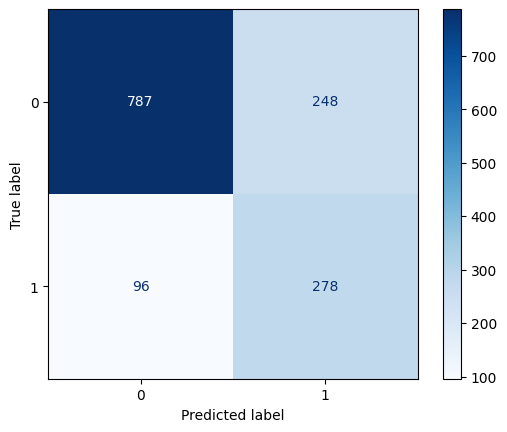

In [ ]:
inicio = time.time()
grid_lgb.fit(X_train, y_train)
fin = time.time()

y_pred_lgb = grid_lgb.predict(X_test)

print("\nResultados - LightGBM")
print(classification_report(y_test, y_pred_lgb))
print("Mejores parámetros:", grid_lgb.best_params_)

ConfusionMatrixDisplay.from_estimator(grid_lgb, X_test, y_test, cmap="Blues")

resultados3.append({
    "Modelo": "LightGBM + HP + is_unbalance=True (GPU)",
    "Accuracy": accuracy_score(y_test, y_pred_lgb),
    "Recall": recall_score(y_test, y_pred_lgb),
    "Precision": precision_score(y_test, y_pred_lgb),
    "F1": f1_score(y_test, y_pred_lgb),
    "AUC": roc_auc_score(y_test, y_pred_lgb),
    "Tiempo (s)": round(fin - inicio, 2),
    "Mejores Parámetros": grid_lgb.best_params_
})

c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


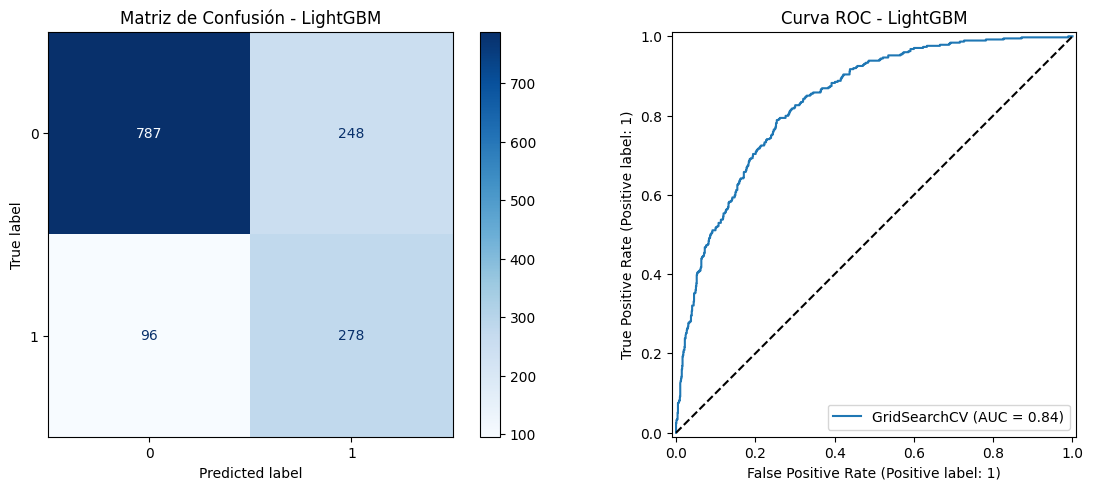

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(grid_lgb, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - LightGBM")

RocCurveDisplay.from_estimator(grid_lgb, X_test, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_title("Curva ROC - LightGBM")
axes[1].legend()

plt.tight_layout()
plt.show()

El conjunto de resultados del **Modelo Hiperparametrizado + Balaceno y GPU** de XGBoost nos da un resultado interesante, presentando un rendimiento de prueba sólido con una **Accuracy de 0.76** y un **AUC de 0.84**. La matriz de confusión demuestra un desempeño normal, enfatizando el desbalance que hay entre las clases, ya que la clase mayoritaria (positiva) tiene mayores tasas de clasificacion a diferencia de la clase negativa. En esta ultima clase, la tasa tanto de positivos como negativos es casi equivalente.

El reporte de clasificación muestra que el modelo es mejor en la identificación de la clase **'0'** (clase 1), logrando un **Recall de 0.75**. Este rendimiento indica una situacion interesante de desbalanceo entre las clases, y veremos si esto cambia a medida que implementemos diversos metodos de balanceo e hiperparametrizacion.

Los mejores parametros fueron: {'clf__colsample_bytree': 1.0, 'clf__max_bin': 255, 'clf__min_child_samples': 50, 'clf__min_child_weight': 0.001, 'clf__reg_alpha': 0, 'clf__reg_lambda': 0.5, 'clf__subsample': 0.8}

### **2.3.5 Resultados preliminares**

In [ ]:
res3_df = pd.DataFrame(resultados3)
res3_df_sorted = res3_df.sort_values(by="Recall", ascending=False)
print("\n Resultados finales:")
display(res3_df_sorted)


 Resultados finales:


,Modelo,Accuracy,Recall,Precision,F1,AUC,Tiempo (s),Mejores Parámetros
1,XGBoost + HP + scale_pos_weight=w1 (GPU),0.707594,0.839572,0.471471,0.603846,0.749738,361.79,"{'clf__gamma': 1, 'clf__min_child_weight': 5, ..."
2,LightGBM + HP + is_unbalance=True (GPU),0.755855,0.743316,0.528517,0.617778,0.751851,302.20,"{'clf__colsample_bytree': 1.0, 'clf__max_bin':..."
0,RandomForest + HP + SMOTE (GPU),0.762243,0.639037,0.544419,0.587946,0.722900,41.86,"{'clf__bootstrap': True, 'clf__criterion': 'gi..."


In [ ]:
metricas = ["Accuracy", "Recall", "Precision", "F1", "AUC"]

res3_df_sorted = res3_df.sort_values(by="Recall", ascending=False).reset_index(drop=True)

res3_melt = res3_df_sorted.melt(
    id_vars="Modelo", 
    value_vars=metricas, 
    var_name="Métrica", 
    value_name="Valor"
)

C:\Users\taran\AppData\Local\Temp\ipykernel_19104\216536320.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


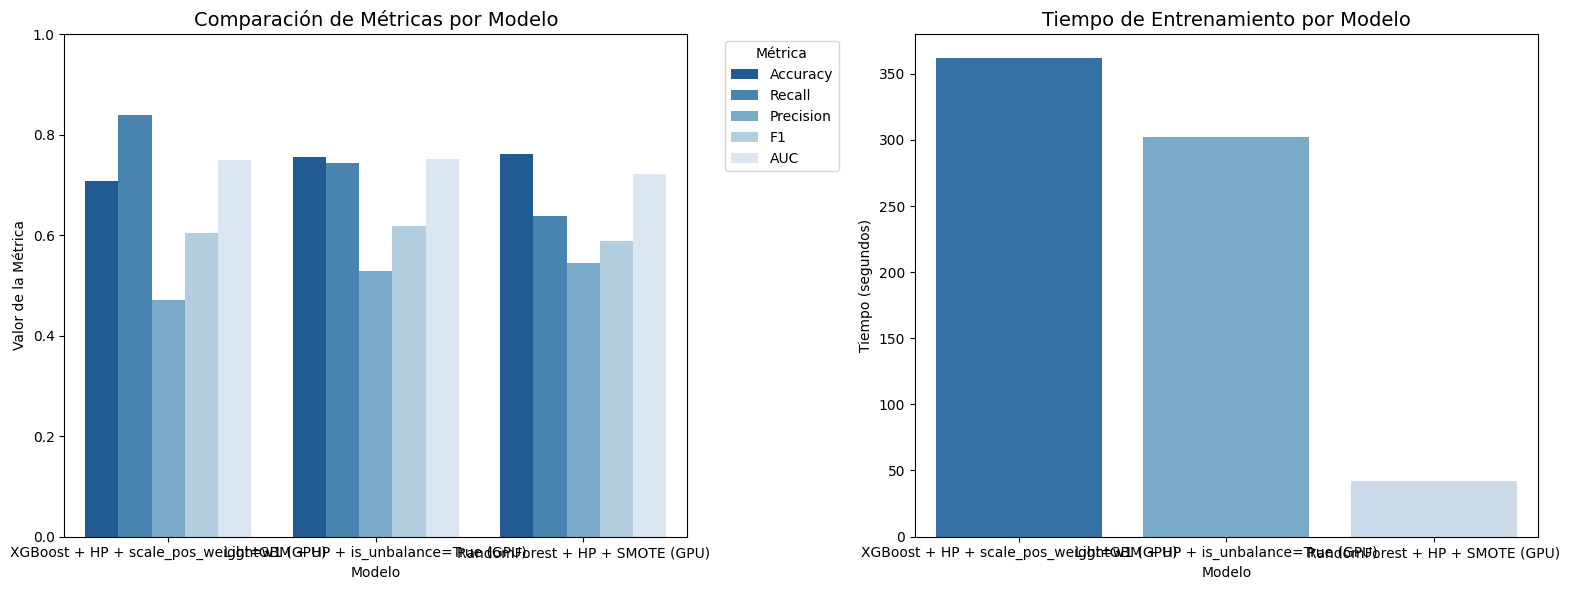

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(
    data=res3_melt, 
    x="Modelo", 
    y="Valor", 
    hue="Métrica", 
    palette="Blues_r", 
    ax=axes[0]
)
axes[0].set_title("Comparación de Métricas por Modelo", fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("Valor de la Métrica")
axes[0].set_xlabel("Modelo")
axes[0].legend(title="Métrica", bbox_to_anchor=(1.05, 1), loc="upper left")

sns.barplot(
    data=res3_df_sorted, 
    x="Modelo", 
    y="Tiempo (s)", 
    palette="Blues_r", 
    ax=axes[1]
)
axes[1].set_title("Tiempo de Entrenamiento por Modelo", fontsize=14)
axes[1].set_ylabel("Tiempo (segundos)")
axes[1].set_xlabel("Modelo")

plt.tight_layout()
plt.show()


De forma preliminar, vemos que los modelos de XGBoost y LightGBM tienen mejores metricas al comparar con otros modelos. En este caso, la metrica de interes es Recall (ya que queremos reducir los falsos negativos para este caso), y XGBoost alcanzó los mejores rendimientos. Junto a esto, notamos que XGBoost tuvo una duracion elevada a comparacion del resto (LightGBM y RandomForest)

Los modelos de XGBoost y RandomForest fueron los que menos duracion tuvieron a la hora de ejecutar.

c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


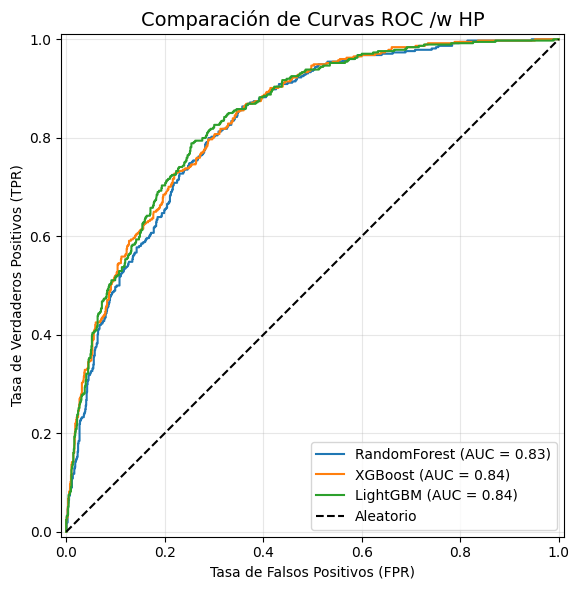

In [ ]:
plt.figure(figsize=(8, 6))

modelos_entrenados = {
    "RandomForest": grid_rf,
    "XGBoost": grid_xgb,
    "LightGBM": grid_lgb
}

for name, model in modelos_entrenados.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=plt.gca(), name=name)

plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")

plt.title("Comparación de Curvas ROC /w HP", fontsize=14)
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Comparando curvas ROC, los rendimientos son bastantes similares a la grafica anterior, con LightGBM y XGBoost con un AUC de 0.84, con los modelos restantes estando con 0.83 (RandomForest) respectivamente, teniendo un desempeño muy similar en comparacion.

## **2.4 Resultados generales**

In [ ]:
res_all = pd.concat([res1_df, res2_df, res3_df], ignore_index=True)

res_all_sorted = res_all.sort_values(by="Recall", ascending=False)

print("\nResultados combinados:")
display(res_all_sorted)


Resultados combinados:


,Modelo,Accuracy,Recall,Precision,F1,AUC,Tiempo (s),Mejores Parámetros
5,XGBoost + HP,0.708304,0.847594,0.472429,0.606699,0.752782,24.53,"{'clf__gamma': 1, 'clf__min_child_weight': 5, ..."
9,XGBoost + HP + scale_pos_weight=w1 (GPU),0.707594,0.839572,0.471471,0.603846,0.749738,361.79,"{'clf__gamma': 1, 'clf__min_child_weight': 5, ..."
10,LightGBM + HP + is_unbalance=True (GPU),0.755855,0.743316,0.528517,0.617778,0.751851,302.20,"{'clf__colsample_bytree': 1.0, 'clf__max_bin':..."
8,RandomForest + HP + SMOTE (GPU),0.762243,0.639037,0.544419,0.587946,0.722900,41.86,"{'clf__bootstrap': True, 'clf__criterion': 'gi..."
6,CatBoost + HP,0.791341,0.545455,0.621951,0.581197,0.712824,30.81,"{'clf__border_count': 32, 'clf__l2_leaf_reg': 1}"
2,CatBoost,0.793471,0.521390,0.635179,0.572687,0.706589,8.13,{}
3,LightGBM,0.794890,0.521390,0.639344,0.574374,0.707555,0.93,{}
7,LightGBM + HP,0.792051,0.510695,0.634551,0.565926,0.702207,42.95,"{'clf__colsample_bytree': 1.0, 'clf__max_bin':..."
1,XGBoost,0.777857,0.508021,0.595611,0.548341,0.691692,0.64,{}
4,RandomForest + HP,0.797729,0.497326,0.657244,0.566210,0.701803,25.00,"{'clf__bootstrap': True, 'clf__criterion': 'gi..."


In [ ]:
metricas = ["Accuracy", "Recall", "Precision", "F1", "AUC"]

res_all_melt = res_all.melt(
    id_vars=["Modelo"], 
    value_vars=metricas,
    var_name="Métrica",
    value_name="Valor"
)


C:\Users\taran\AppData\Local\Temp\ipykernel_19104\3250643461.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(
C:\Users\taran\AppData\Local\Temp\ipykernel_19104\3250643461.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\taran\AppData\Local\Temp\ipykernel_19104\3250643461.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(


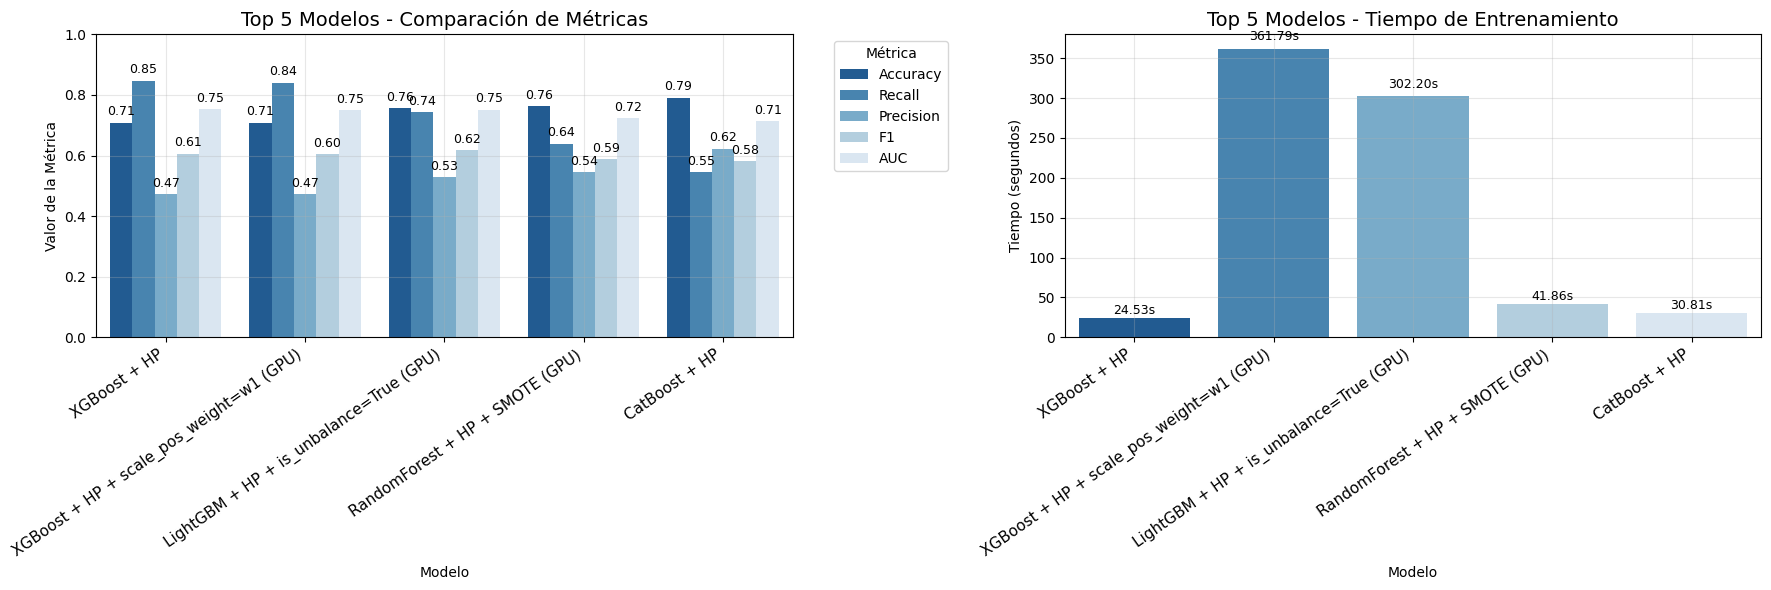

In [ ]:
top5 = res_all_sorted.nlargest(5, "Recall")

top5_melt = top5.melt(
    id_vars=["Modelo"],
    value_vars=["Accuracy", "Recall", "Precision", "F1", "AUC"],
    var_name="Métrica",
    value_name="Valor"
)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(
    data=top5_melt, 
    x="Modelo", 
    y="Valor", 
    hue="Métrica", 
    palette="Blues_r", 
    ax=axes[0]
)

axes[0].set_title("Top 5 Modelos - Comparación de Métricas", fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("Valor de la Métrica")
axes[0].set_xlabel("Modelo")
axes[0].grid(alpha=0.3)

axes[0].set_xticklabels(
    axes[0].get_xticklabels(),
    rotation=35,
    ha="right",
    fontsize=11
)

for p in axes[0].patches:
    value = p.get_height()
    if not np.isnan(value) and value > 0.01:  
        axes[0].text(
            p.get_x() + p.get_width() / 2,
            value + 0.015,
            f"{value:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="black"
        )

axes[0].legend(title="Métrica", bbox_to_anchor=(1.05, 1), loc="upper left")

sns.barplot(
    data=top5, 
    x="Modelo", 
    y="Tiempo (s)", 
    palette="Blues_r", 
    ax=axes[1]
)

axes[1].set_title("Top 5 Modelos - Tiempo de Entrenamiento", fontsize=14)
axes[1].set_ylabel("Tiempo (segundos)")
axes[1].set_xlabel("Modelo")
axes[1].grid(alpha=0.3)

axes[1].set_xticklabels(
    axes[1].get_xticklabels(),
    rotation=35,
    ha="right",
    fontsize=11
)

for p in axes[1].patches:
    value = p.get_height()
    if not np.isnan(value):
        axes[1].text(
            p.get_x() + p.get_width() / 2,
            value + (value * 0.02),
            f"{value:.2f}s",
            ha="center",
            va="bottom",
            fontsize=9,
            color="black"
        )

plt.tight_layout()
plt.show()


Tras todos los modeladados, tenemos estos resultados en base a las metricas que hemos planteado. En base a esto, vemos que los mejores modelos fueron una combinacion entre hiperparametrizar, usar balaceno y GPU. Para esto, observaremos los mejores tres modelos:

- El mejor modelo a estudio fue XGBoost + Hiperparametros, que alcanzo 0.848 en recall.Y tuvo el menor tiempo de computo a comparacion del resto de los modelos.

- El segundo mejor modelo fue una combinacion de XGBoost + Hiperparametros y tecnicas de balanceo, que a pesar de tener un tiempo de computo elevado, tuvo una metrica de recall global de 0.840.

- En tercer lugar fue el modelo de LightGBM con las mismas especificaciones que el segundo modelo, que tuvo un desempeño moderado, con un recall global de 0.743.

C:\Users\taran\AppData\Local\Temp\ipykernel_19104\329827691.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


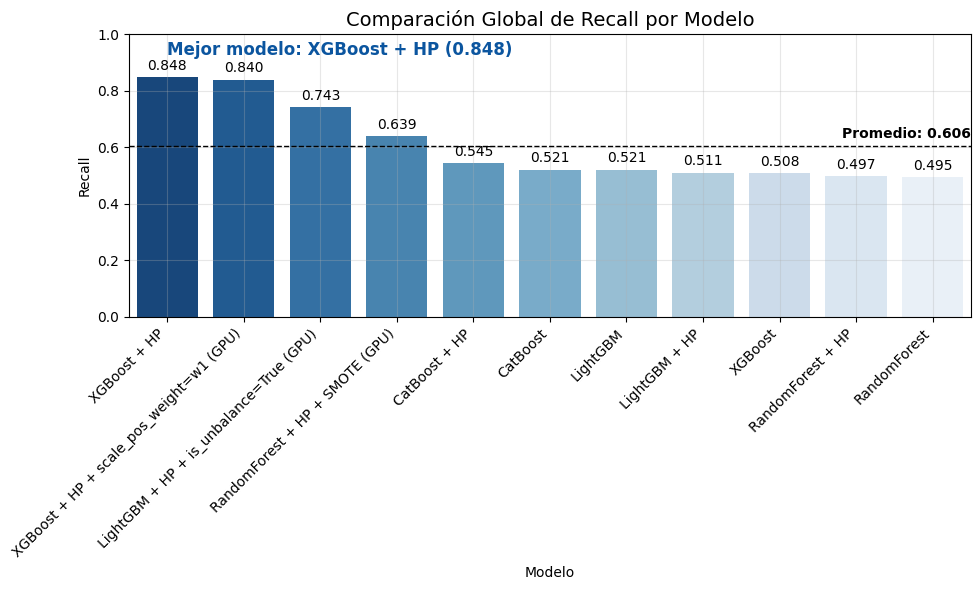

In [ ]:
plt.figure(figsize=(10, 6))

res_sorted = res_all_sorted.sort_values("Recall", ascending=False)

sns.barplot(
    data=res_sorted,
    x="Modelo",
    y="Recall",
    palette="Blues_r"
)

plt.title("Comparación Global de Recall por Modelo", fontsize=14)
plt.ylabel("Recall")
plt.xlabel("Modelo")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)

for i, val in enumerate(res_sorted["Recall"]):
    plt.text(
        i,
        val + 0.015,  
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=10,
        color="black"
    )

mean_recall = res_sorted["Recall"].mean()
plt.axhline(mean_recall, color="black", linestyle="--", linewidth=1)
plt.text(
    len(res_sorted) - 0.5, mean_recall + 0.015,
    f"Promedio: {mean_recall:.3f}",
    color="black",
    fontsize=10,
    ha="right",
    va="bottom",
    fontweight="bold"
)

best_model = res_sorted.iloc[0]
offset = 0.08 
plt.text(
    x=0,
    y=min(best_model["Recall"] + offset, 0.98), 
    s=f"Mejor modelo: {best_model['Modelo']} ({best_model['Recall']:.3f})",
    fontsize=12,
    color=sns.color_palette("Blues")[-1],
    fontweight="bold"
)

plt.tight_layout()
plt.show()


Observandolo de otra perspectiva, esta es una comparacion solamente de recall por modelos, observando los valores que hay entre los diferentes modelos, de forma ascendente, con el promedio de los modelos tambien especificado. Aqui, XGBoost + HP fue coronado como el mejor modelo en terminos de tanto metricas globales, como en la metrica objetivo, la cual fue Recall.